# Project Part 2: Traning The Song Popularity Score Prediction Model

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/cdinh92/CS39AA-project/blob/main/project_part2.ipynb)

Welcome to the data science project undertaken for the CS39AA NLP Machine Learning class at MSU Denver. In this exploration, the aim is to delve into the world of music industry and investigate whether a predictive model can be designed to forecast the success of songs based on the popularity scores. The focus of this analysis lies on 8 key song features: danceability, energy, mode, loudness, speechiness, instrumentalness, tempo, and valence.

**Check the Project Part 1 [here](https://github.com/cdinh92/CS39AA-Project/blob/main/project_part1.ipynb)**

## 1. Introduction

After exploring the Spotify top songs dataset by Joakim Arvidsson on [Kaggle](https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs), I reduce it to nearly 15000 songs in the clean file named [filtered_spotify_songs.csv](https://github.com/cdinh92/CS39AA-Project/blob/main/filtered_spotify_songs.csv). Now, as we step into the training phase, three formidable models — **Random Forest**, **Decision Tree**, and **Linear Regression** — take center stage for a comparative analysis

**Initial Prediction:**
Early predictions lean towards **Random Forest** outperforming, especially on large datasets typical of regression problems. However, this model pose a major challenge that it can’t extrapolate outside unseen data. We’ll dive deeper into these challenge later.

**Alternative Approach:**
_While recognizing the potential limitations of predictive models in capturing the entirety of a song's success factors, this project might also seeks to identify common features among trending songs, just in case the predictive results are far from expectations._

## 2. Training the predicting models

Let's explore the dataset and see if we could trim the dataset and eliminate irrelevant columns.

In [127]:
# import all of the python modules/packages
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import RobustScaler
# Check the filtered spotify songs csv file
try:
    raw_data = pd.read_csv("filtered_spotify_songs.csv")
    print("CSV file found and loaded.")
except FileNotFoundError:
    raw_data = pd.read_csv("https://raw.githubusercontent.com/cdinh92/CS39AA-Project/main/filtered_spotify_songs.csv")

# Specify the columns to keep
columns_to_keep = ['track_popularity','danceability','energy','speechiness','loudness','mode','instrumentalness','valence','tempo']
# Use loc to select only the specified columns
data = raw_data.loc[:, columns_to_keep]
data.info()

CSV file found and loaded.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14925 entries, 0 to 14924
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_popularity  14925 non-null  int64  
 1   danceability      14925 non-null  float64
 2   energy            14925 non-null  float64
 3   speechiness       14925 non-null  float64
 4   loudness          14925 non-null  float64
 5   mode              14925 non-null  int64  
 6   instrumentalness  14925 non-null  float64
 7   valence           14925 non-null  float64
 8   tempo             14925 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 1.0 MB


**1. Random Forest**

In [116]:
""" This is for different approach """
# Create target object and call it y
Y = data.track_popularity
# Create X
features = ['danceability','energy','speechiness','loudness','mode','instrumentalness','valence','tempo']
X = data[features]

scaler = RobustScaler()
data = scaler.fit_transform(data.astype(np.float64))
data = scaler.fit_transform(data.astype(np.int64))

#Split into validation and training data
x_train, x_test, y_train, y_test = train_test_split(X,Y, random_state= 42)

#fit decision tree
tree = DecisionTreeRegressor()
tree.fit(x_train, y_train)
#fit random forest
forest = RandomForestRegressor(n_jobs=-1)
forest.fit(x_train, y_train)
#fit regression
lin_reg = LinearRegression(n_jobs=-1)
lin_reg.fit(x_train, y_train)



LinearRegression(n_jobs=-1)

In [117]:
models= [('lin_reg', lin_reg), ('random forest', forest), ('decision tree', tree)]
for i, model in models:    
    predictions = model.predict(x_train)
    MSE = mean_squared_error(y_train, predictions)
    RMSE = np.sqrt(MSE)
    msg = "%s = %.2f" % (i, round(RMSE, 2))
    print('RMSE of', msg)

RMSE of lin_reg = 20.78
RMSE of random forest = 8.24
RMSE of decision tree = 3.02


In [119]:
print(lin_reg.score(x_train,y_train))
print(forest.score(x_train,y_train))
print(tree.score(x_train,y_train))

0.06645154240111695
0.8534248686331012
0.9802629622561101


In [120]:
models= [('lin_reg', lin_reg), ('forest', forest), ('dt', tree)]
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

#for each model I want to test three different scoring metrics. Therefore, results[0] will be lin_reg x MSE, 
# results[1] lin_reg x MSE and so on until results [8], where we stored dt x r2

results= []
metric= []
for name, model in models:
    for i in scoring:
        scores = cross_validate(model, x_train, y_train, scoring=i, cv=10, return_train_score=True)
        results.append(scores)

In [90]:
#THIS IS FOR Linear regression
#if you change signa and square the Mean Square Error you get the RMSE, which is the most common metric to accuracy
LR_RMSE_mean = np.sqrt(-results[0]['test_score'].mean())
LR_RMSE_std= results[0]['test_score'].std()
# note that also here I changed the sign, as the result is originally a negative number for ease of computation
LR_MAE_mean = -results[1]['test_score'].mean()
LR_MAE_std= results[1]['test_score'].std()
LR_r2_mean = results[2]['test_score'].mean()
LR_r2_std = results[2]['test_score'].std()

#THIS IS FOR RF
RF_RMSE_mean = np.sqrt(-results[3]['test_score'].mean())
RF_RMSE_std= results[3]['test_score'].std()
RF_MAE_mean = -results[4]['test_score'].mean()
RF_MAE_std= results[4]['test_score'].std()
RF_r2_mean = results[5]['test_score'].mean()
RF_r2_std = results[5]['test_score'].std()

#THIS IS FOR DT
DT_RMSE_mean = np.sqrt(-results[6]['test_score'].mean())
DT_RMSE_std= results[6]['test_score'].std()
DT_MAE_mean = -results[7]['test_score'].mean()
DT_MAE_std= results[7]['test_score'].std()
DT_r2_mean = results[8]['test_score'].mean()
DT_r2_std = results[8]['test_score'].std()

In [91]:
modelDF = pd.DataFrame({
    'Model'       : ['Linear Regression', 'Random Forest', 'Decision Trees'],
    'RMSE_mean'    : [LR_RMSE_mean, RF_RMSE_mean, DT_RMSE_mean],
    'RMSE_std'    : [LR_RMSE_std, RF_RMSE_std, DT_RMSE_std],
    'MAE_mean'   : [LR_MAE_mean, RF_MAE_mean, DT_MAE_mean],
    'MAE_std'   : [LR_MAE_std, RF_MAE_std, DT_MAE_std],
    'r2_mean'      : [LR_r2_mean, RF_r2_mean, DT_r2_mean],
    'r2_std'      : [LR_r2_std, RF_r2_std, DT_r2_std],
    }, columns = ['Model', 'RMSE_mean', 'RMSE_std', 'MAE_mean', 'MAE_std', 'r2_mean', 'r2_std'])

modelDF.sort_values(by='r2_mean', ascending=False)

,Model,RMSE_mean,RMSE_std,MAE_mean,MAE_std,r2_mean,r2_std
0,Linear Regression,20.800113,12.190990,16.769144,0.296540,0.064752,0.014759
1,Random Forest,21.066113,13.142958,16.729670,0.268392,0.034657,0.025513
2,Decision Trees,29.259618,23.140512,23.100166,0.504789,-0.868113,0.049645


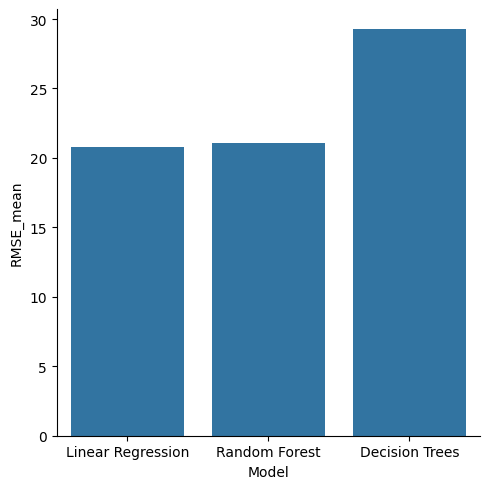

In [92]:
sns.catplot(x= 'Model', y= 'RMSE_mean', data= modelDF, kind='bar', legend=True)

Now decision trees are not so good in comparison with the other two methods, both in terms of error and variance explained. The best model is random forest, though I must say that I expected it to outperform linear regression by a wider margin. In any case, let's proceed with fine tuning our random forest.

In [93]:
param_grid = { 
    'n_estimators': [25, 50, 100, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
} 

In [77]:
grid_search = GridSearchCV(RandomForestRegressor(), 
                           param_grid=param_grid) 
grid_search.fit(x_train, y_train) 
print(grid_search.best_estimator_) 

RandomForestRegressor(max_depth=6, max_features=None, max_leaf_nodes=9,
                      n_estimators=150)


In [ ]:
model_grid = RandomForestRegressor(max_depth=6, 
                                    max_features=None, 
                                    max_leaf_nodes=9, 
                                    n_estimators=150) 
model_grid.fit(x_train, y_train) 
y_pred_grid = model_grid.predict(x_test) 
accuracy = accuracy_score(y_test, y_pred_grid)
print(f'Accuracy: {accuracy:.2f}')
conf_matrix = confusion_matrix(y_test, y_pred_grid)
print('Confusion Matrix:')
print(conf_matrix)
class_report = classification_report(y_test, y_pred_grid)
print('Classification Report:')
print(class_report)

In [ ]:
""" 
This is the evaluate function copied from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 
Just put it here in case I will use it later
"""
def evaluate(model, x_test, y_test):
    predictions = model.predict(x_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, x_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [ ]:

""" This is my initial training part """
#Set up features
features = ['track_popularity','danceability','energy','speechiness','loudness','mode','instrumentalness','valence','tempo']
data1 = data[features]
training_data, testing_data = train_test_split(data1, test_size=0.2, random_state=25)

print(f"Training examples: {training_data.shape[0]}")
print(f"Testing examples: {testing_data.shape[0]}")

# testing_data.info()

#Dropping Popularity Scores Column From Test data
testing_data_score=testing_data['track_popularity']
testing_data=testing_data.drop('track_popularity', axis=1)
testing_data.head()

#Setting training data into x_train and y_train
x_train=training_data.drop('track_popularity',axis=1)
y_train=training_data['track_popularity']

#Shapes of x_train,y_train and test data
x_train.shape, y_train.shape, testing_data.shape

#Random Forest Regression
rf_model=RandomForestRegressor(n_estimators=50)
rf_model.fit(x_train,y_train)
print(rf_model.score(x_train,y_train))

#Making predictions on test set 
rf_predict=rf_model.predict(testing_data)

rf_output=pd.DataFrame({'Track ID':testing_data.index,'Predicted Popularity Score':rf_predict,'Actual Popularity Score':testing_data_score})
print(rf_output)